In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [3]:
archetype_data = pd.read_csv('../../data/enriched/persona_identification/archetype_predictions_joined.csv')

character_data = pd.read_csv('../../data/MovieSummaries/alex_character_processed.csv')

character_data = character_data.rename(columns={
    'Wikipedia movie ID': "wikipedia_movie_id",
    'Freebase movie ID': "fb_movie_id",
    'Character name': "character_name",
    'Actor gender': "actor_gender",
    'Actor height (in meters)': "actor_height",
    'Actor ethnicity (Freebase ID)': "fb_actor_eth_id",
    'Actor name': "actor_name",
    'Freebase character/actor map ID': "fb_char_actor_map_id",
    'Freebase character ID': "fb_char_id",
    'Freebase actor ID': "fb_actor_id",
})

character_data = character_data.drop_duplicates(subset=["fb_movie_id", "fb_actor_id", "character_name"])

actor_data = pd.read_csv('../../data/enriched/actors/actors_freebase.csv')
actor_data = actor_data[["education", "professions_num", "date_of_birth", "nationality", "gender", "place_of_birth", "height", "weight", "religion", "id"]]

merged = pd.merge(
    archetype_data, 
    character_data, 
    how="inner", 
    left_on=["actor_fb_id", "movie_fb_id", "character_name"], 
    right_on=["fb_actor_id", "fb_movie_id", "character_name"]
)
merged = pd.merge(merged, actor_data, how="left", left_on="actor_fb_id", right_on="id").copy()

merged.loc[merged.actor_height.isna() & ~merged.height.isna(), "actor_height"] = merged[merged.actor_height.isna() & ~merged.height.isna()].height
merged.loc[merged.actor_gender.isna() & ~merged.gender.isna(), "actor_gender"] = merged[merged.actor_gender.isna() & ~merged.gender.isna()].gender

data = merged[[
    'prediction', 'character_name',
    'movie_name', 'actor_gender', 'actor_height',
    'actor_name', 'actor_date_of_birth', 'movie_release_date', 'ethn_name',
    'race', 'education', 'professions_num', 'nationality',
    'gender', 'place_of_birth', 'weight', 'religion', "fb_movie_id", "fb_actor_id"
]].copy()
# # delete some ourliers, by looking at the histogram
MIN_HEIGHT = 0.8
MAX_HEIGHT = 2.7 # Max Palmen had height 249 cm
data = data[((data.actor_height >= MIN_HEIGHT) & (data.actor_height <= MAX_HEIGHT)) | data.actor_height.isna()].copy()
data["years_in_film"] = (pd.to_datetime(data.movie_release_date) - pd.to_datetime(data.actor_date_of_birth)).dt.days / 365.25
data["actor_bmi"] = data.weight / (data.actor_height ** 2)
data.loc[~data.education.isna(), "education"] = data.loc[~data.education.isna(), "education"].astype(int)
data.loc[data.actor_gender == "Male", "actor_gender"] = "M"
data.loc[data.actor_gender == "Female", "actor_gender"] = "F"
data.rename(columns={"prediction": "archetype"}, inplace=True)
data.shape

(87210, 21)

For now we do not have any information about the archetypes so I will randomly generate them

# Question 2

Which Actor Traits Correspond to Specific Archetypes?\
Which actor traits — such as age, gender, ethnicity, and other physical attributes — are typically associated with specific archetypes? For instance, are certain traits more frequently linked to roles like heroes, villains, or mentors? Investigating these correlations can reveal patterns in casting decisions.

In [ ]:
actor_traits_numerical_columns = ["actor_height", "weight", "years_in_film", "actor_bmi"]
actor_traits_categorial_columns = ["actor_gender", "race", "education", "religion", "nationality", "place_of_birth"]

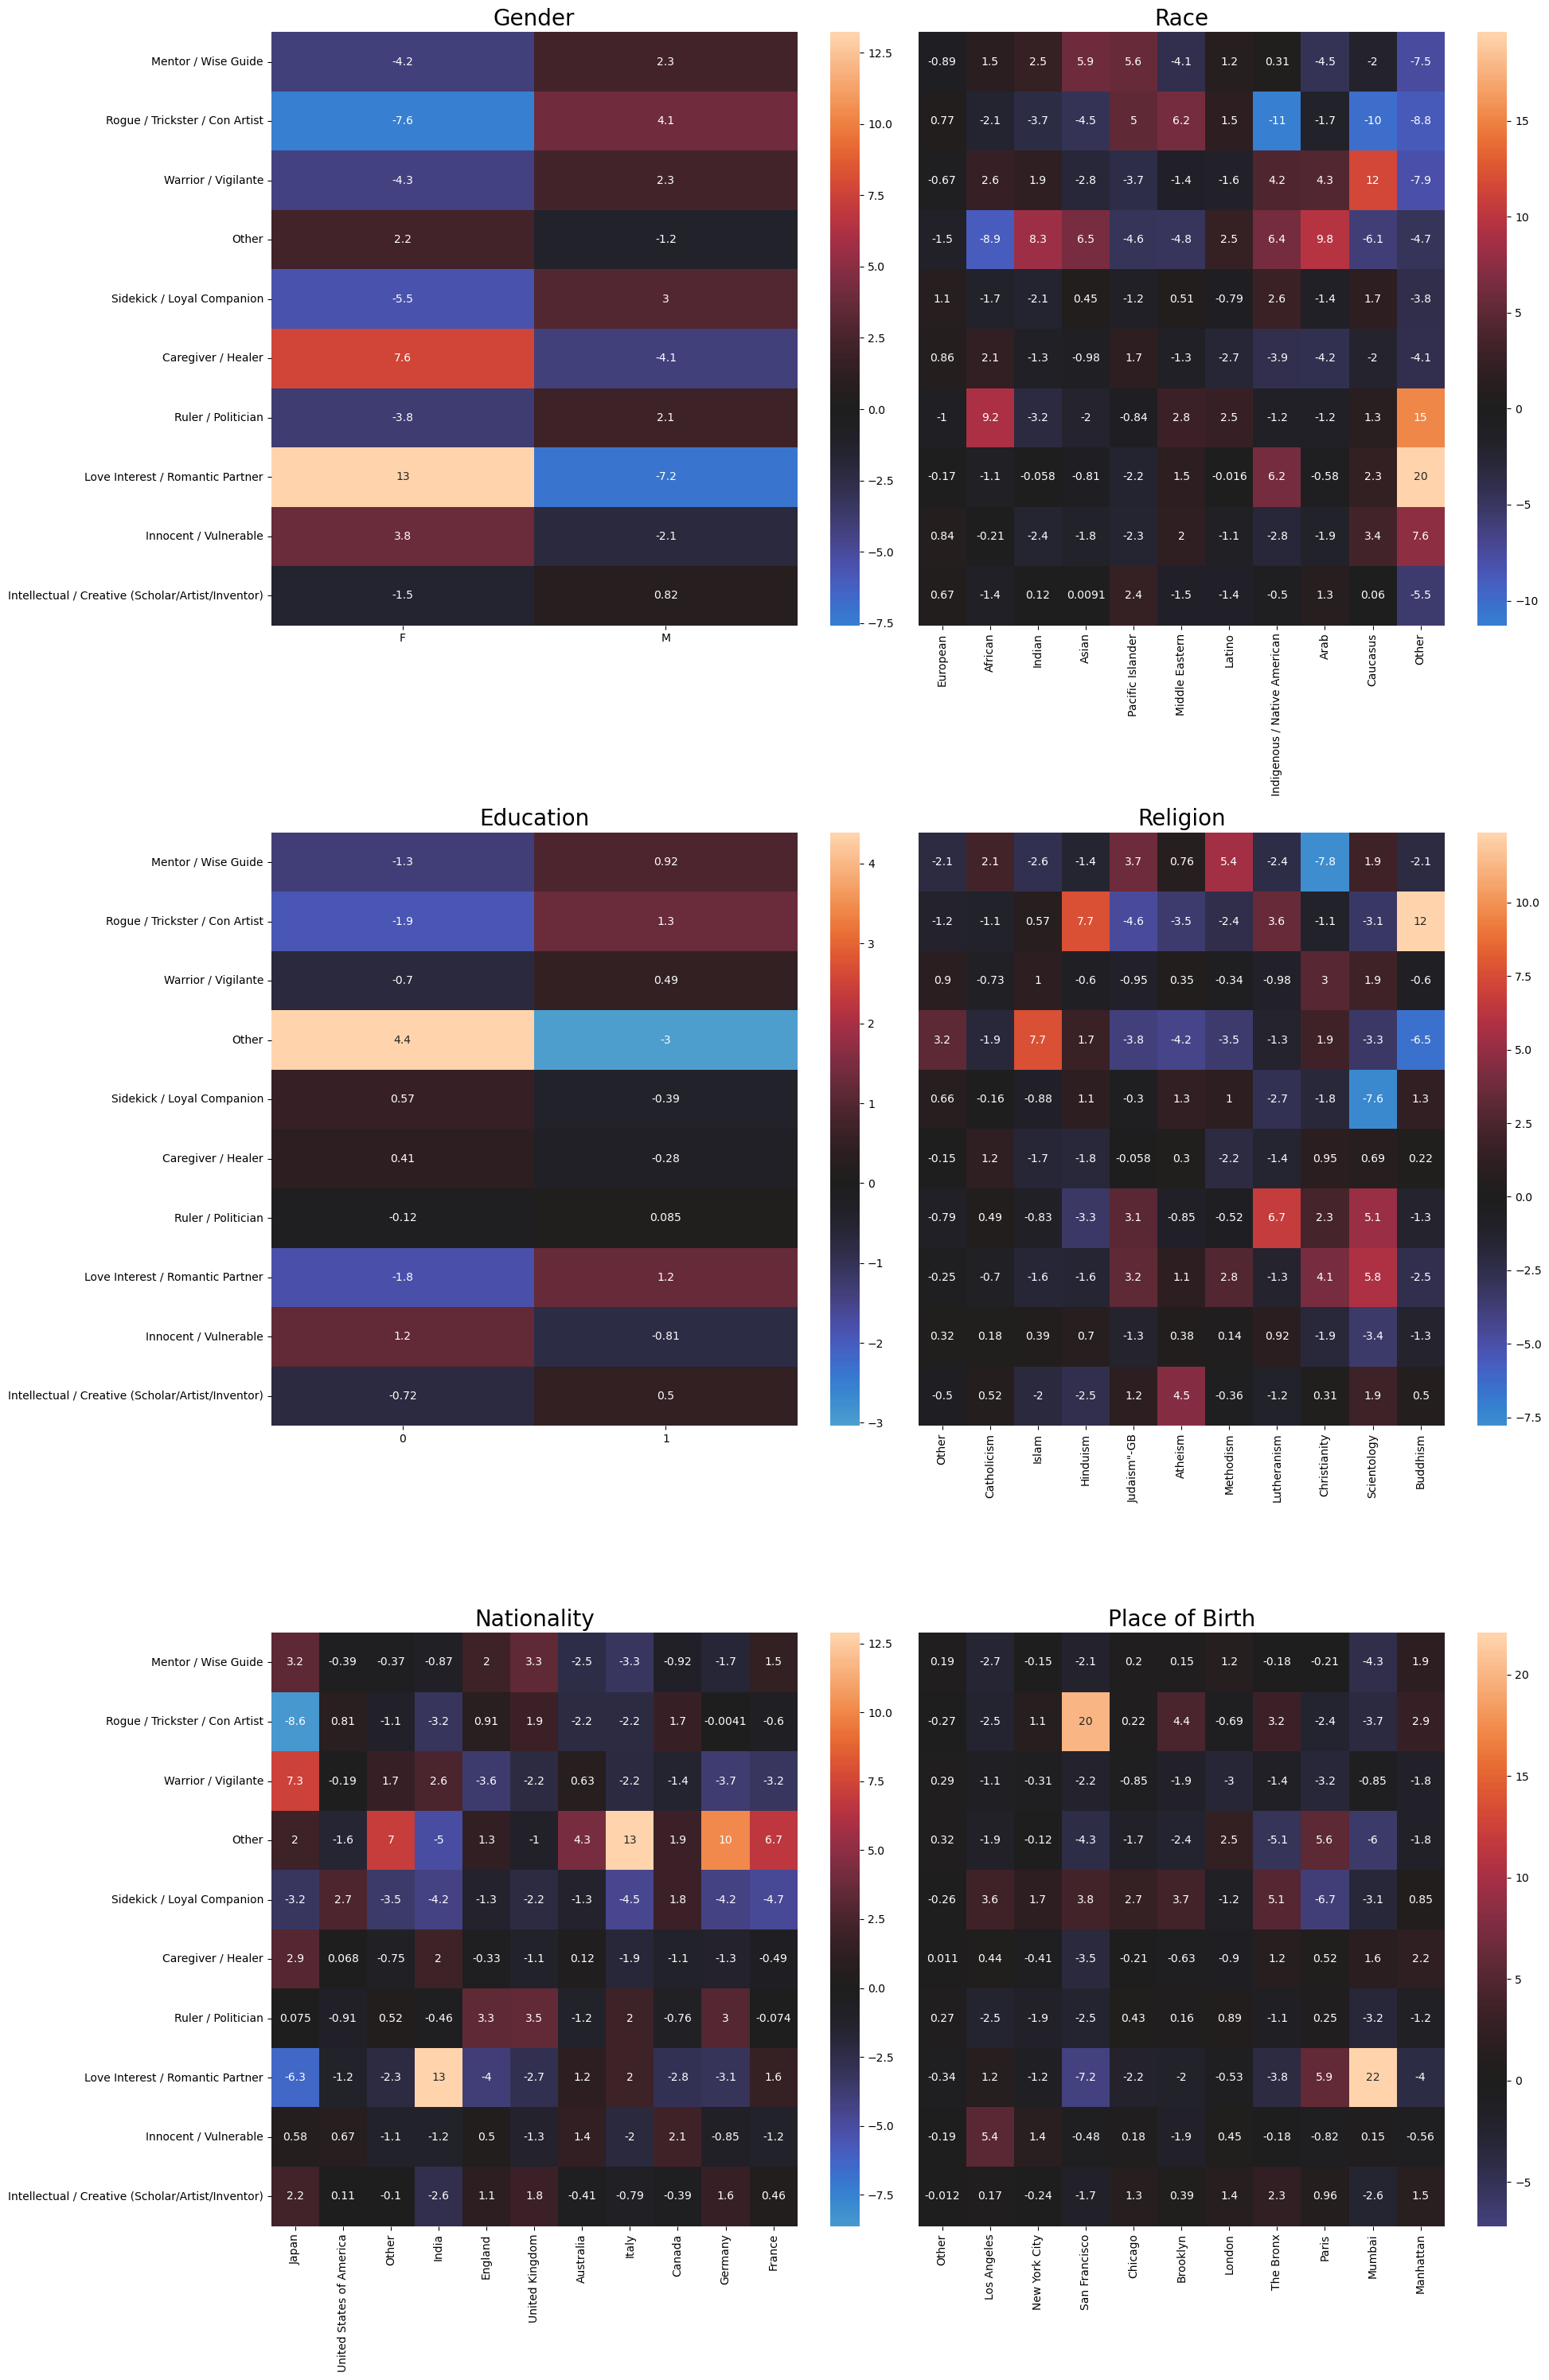

In [82]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), "../visualization"))
from plot_3d_like import histogram_3d_plotly, calculate_ticks_and_norm, plot_2d_heatmap

plt.figure(figsize=(2 * 10, 3 * 10))
for i, (s, title) in enumerate(zip(
    ["actor_gender", "race", "education", "religion", "nationality", "place_of_birth"],
    ["Gender", "Race", "Education", "Religion", "Nationality", "Place of Birth"],
)):
    plt.subplot(3, 2, i + 1)
        
    plt.title(title, fontsize=20)
    grid = plot_2d_heatmap(
        data, s, "archetype", 
        normalize="first", 
        compare_default_value="subtract",
        percentage=True,
    )
    if not i in [0, 2, 4]:
        plt.yticks([])
plt.tight_layout()

To answer this question we need to understand if $P(Archetype)$ differs from $P(Archetype|Feature)$. The heatmap represents $P(Archetype|Feature) - P(Archetype)$. The blue color is for the negative values, and the orange is for the positive ones. \

- Conditioning on `Gender` shows an interesting law --- if the probability to play a specific archetype increases for `Female` actors then it decreases for `Male` actors and vice versa. Actually, it works for every archetype in our dataset, but the most significant ones are `Love Interest/Romantic Partner` (Female +13%, Male -7%), `Caregiver/Healer` (Female +7%, Male -4%), `Rogue / Trickster / Con Artist` (Female -7% Male +4%), `Sidekick / Local Companyon` (Female -5%, Male 3%). 
- Conditioning on `Race` shows that the probability to play `Mentor / Wise Guard` are increases if an actor is `Asian` or `Pacific Islander` (+5%), and decreases if the actor is `Middle Eastern`. The probability to play `Ruler / Politician` increases if an actor is `African` (+10%) and decreases if an actor is `Indian`, the chances to play `Love Interest / Romantic Partner` increases by 6% you the actor is `Indigenous / Native American`.
-  Conditioning on `Education` doesn't show very significant changes in probability. But one can notice that when the probability to play a specific archetype increases for `no education` then it decreases for `education` and vice versa.
- Conditioning on Religion shows interesting results. The probability to play `Mentor / Wise Guide` decreases by 8% if actor is `Christianity`. For `Rogue / Trickster / Con Artist` probability increases on 7.7% if the actor is `Hinduism`
- 


In [135]:
import scipy.stats as sps
xyi = (data.religion.dropna() == "Hinduism")
val1 = (data.iloc[xyi[xyi].index].archetype ==  'Rogue / Trickster / Con Artist').astype(float)
val2 = (data.archetype.dropna() ==  'Rogue / Trickster / Con Artist').astype(float)
sps.ttest_ind(
    val1, val2
)

TtestResult(statistic=np.float64(-1.6233738116405874), pvalue=np.float64(0.10451303522701898), df=np.float64(89654.0))

In [6]:
histograms = []

data_part = data[["archetype", "actor_gender"]].dropna()

categories = data_part["actor_gender"].unique().tolist()
color_map = {
    gender: color for gender, color in zip(categories, plt.cm.tab20.colors[:len(categories)])
}

for category in categories:
    filtered_data = data_part[data_part["actor_gender"] == category]["archetype"]
    histograms.append(
        go.Histogram(
            x=filtered_data,
            name=f'Category {category}', 
            visible=False, 
            histnorm='probability density',
        )
    )

# the first is visible
histograms[0].visible = True

fig = go.Figure(data=histograms)

# create buttons
buttons = []
for i, category in enumerate(categories):
    button = {
        "label": category,
        "method": "update",
        "args": [
            {
                "visible": [j == i for j in range(len(categories))],
                "opacity": [1.0] * len(categories),
            },
            {"title": f"Histogram for {category}"},
        ]
    }
    buttons.append(button)

buttons.append(
     {
        "label": "all",
        "method": "update",
        "args": [
            {
                "visible": [True] * len(categories),
                "opacity": [0.3] * len(categories),
            },
            {"title": f"Histogram for {category}"},
        ],
    }  
)

# Add the buttons to the layout
fig.update_layout(
    updatemenus=[
        {
            "type": "dropdown",
            "direction": "down", 
            "showactive": True, 
            "buttons": buttons
        }
    ],
    title=f"Histogram by Category {categories[0]}",
    xaxis_title="Value Real",
    yaxis_title="Density",
    bargap=0.01,
    barmode='overlay',
)

fig.show()

For real data

# Question 3

Do Casting Patterns Exhibit Biases Based on Actor Traits?\
Do casting patterns exhibit biases based on actor traits like age, gender, or ethnicity? Are there noticeable trends in how certain demographics are cast in specific roles? Examining these patterns can shed light on potential biases within the casting industry.

<Axes: xlabel='archetype', ylabel='age_at_film'>

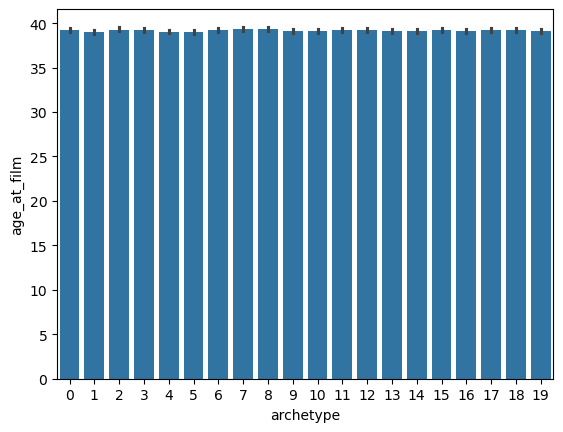

In [56]:
sns.barplot(data_actors, x="archetype", y="age_at_film")

In [ ]:
data_part = data_actors[["archetype", "age_at_film", "movie_release_date"]].dropna().copy()
data_part["year"] = data_part["movie_release_date"].dt.year
data_part = data_part[["archetype", "year", "age_at_film"]].groupby(["archetype", "year"]).mean().reset_index()

In [64]:

categories = data_part["archetype"].unique().tolist()
color_map = {
    cat: color for cat, color in zip(categories, plt.cm.tab20.colors[:len(categories)])
}

lines = []
for category in categories:
    filtered_data = data_part[data_part["archetype"] == category]
    lines.append(
        go.Scatter(
            x=filtered_data["year"],
            y=filtered_data["age_at_film"],
            name=f'{category}', 
            visible=False, 
            mode='lines',
        )
    )

# the first is visible
lines[0].visible = True

fig = go.Figure(data=lines)

# create buttons
buttons = []
for i, category in enumerate(categories):
    button = {
        "label": category,
        "method": "update",
        "args": [
            {
                "visible": [j == i for j in range(len(categories))],
                "opacity": [1.0] * len(categories),
            },
            {"title": f"Plot for {category}"},
        ]
    }
    buttons.append(button)

buttons.append(
     {
        "label": "all",
        "method": "update",
        "args": [
            {
                "visible": [True] * len(categories),
                "opacity": [0.3] * len(categories),
            },
            {"title": f"Histogram for {category}"},
        ],
    }  
)

# Add the buttons to the layout
fig.update_layout(
    updatemenus=[
        {
            "type": "dropdown",
            "direction": "down", 
            "showactive": True, 
            "buttons": buttons
        }
    ],
    title=f"Histogram by Category {categories[0]}",
    xaxis_title="Value Real",
    yaxis_title="Density",
    bargap=0.01,
    barmode='overlay',
)

fig.show()

In [ ]:
fig = px.line(data_part, x="year", y="age_at_film", color="archetype", title="Age at Film by Year")
fig.show()

In [ ]:
sns.barplot(data_actors, x="archetype", y="actor_height")

In [ ]:
sns.boxplot(data_actors, x="archetype", y="full_name_length", showfliers=False)